## Do Not change the following cell, just run it

In [1]:
## From stackoverflow: https://stackoverflow.com/questions/12544056/how-do-i-get-the-current-ipython-jupyter-notebook-name/52187331#

from notebook import notebookapp
import urllib
import json
import os
import ipykernel

def notebook_path():
    """Returns the absolute path of the Notebook or None if it cannot be determined
    NOTE: works only when the security is token-based or there is also no password
    """
    connection_file = os.path.basename(ipykernel.get_connection_file())
    kernel_id = connection_file.split('-', 1)[1].split('.')[0]

    for srv in notebookapp.list_running_servers():
        try:
            if srv['token']=='' and not srv['password']:  # No token and no password, ahem...
                req = urllib.request.urlopen(srv['url']+'api/sessions')
            else:
                req = urllib.request.urlopen(srv['url']+'api/sessions?token='+srv['token'])
            sessions = json.load(req)
            for sess in sessions:
                if sess['kernel']['id'] == kernel_id:
                    return os.path.join(srv['notebook_dir'],sess['notebook']['path'])
        except:
            pass  # There may be stale entries in the runtime directory 
    return None

import sys, os, os.path as osp
sys.path += [osp.dirname(osp.dirname(osp.realpath(notebook_path()))), osp.dirname(osp.realpath(notebook_path()))]

In [2]:
import pandas as pd
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
pd.options.display.max_columns = 2000
pd.options.display.max_rows = 400


from pathlib import Path
# from cfg.globals import *
sys.path += [str(Path(__file__ if '__file__' in dir() else ".")
                 .resolve().parent.parent)]

import numpy as np
import pandas as pd

/var/folders/k1/zf0rv7y54_q54zt_vm6nfm040000gn/T/ipykernel_77015/2884460197.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## From now on, use the notebook :-)

In [3]:
# !%matplotlib qt
import os
from pathlib import Path
import sys
import glob
import numpy as np
import mne
import pyxdf
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime, timezone
import pickle
from sklearn.preprocessing import LabelEncoder
import offline.utils as utils
from offline.utils import load_xdf_data

sys.path += [str(Path(__file__ if '__file__' in dir() else ".")
                 .resolve().parent)]

## Reload

In [4]:
import importlib
importlib.reload(utils)
from offline.utils import load_xdf_data


In [5]:
import pickle
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import copy
import mne
# from mne.channels import find_ch_adjacency, make_1020_channel_selections
from mne.stats import spatio_temporal_cluster_test

np.random.seed(0)

from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch

from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif,  RFECV

from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA, NMF

import  scipy
from scipy import stats


import time
# Import required packages
import matplotlib as mpl
from pylab import cm
import seaborn as sns
# import matplotlib
# mpl.rcParams['figure.figsize'] = (8, 6)
# plt.rcParams['font.size'] = 15

# # plt.rcParams['legend.fontsize'] = 18
# plt.rcParams['text.usetex'] = False

# plt.rcParams['xtick.direction'] = 'out'
# plt.rcParams['ytick.direction'] = 'out'
# plt.rcParams['xtick.major.size'] = 5.0
# plt.rcParams['xtick.minor.size'] = 5.0
# plt.rcParams['ytick.major.size'] = 5.0
# plt.rcParams['ytick.minor.size'] = 5.0


# plt.rcParams['axes.linewidth'] = lwidth


np.random.seed(0)
import random
random.seed(0)

## Helper funcs

In [6]:
    

def fisher_rank(x_data, y, sort=True):
    n_feat = x_data.shape[1]
    x_c0 = x_data[y==-1][:]
    x_c1 = x_data[y==1][:]

    d = np.zeros(n_feat)
    for f in range(n_feat):
        d[f] = (np.mean(x_c0[:,f])-np.mean(x_c1[:,f]))**2/(np.var(x_c0[:,f])+np.var(x_c1[:,f]))
    r = np.arange(n_feat)
    if sort:
        r = np.flip( np.argsort(d))
    return r, d[r]



In [7]:

exp_durations = {
    "highlight_length": 0.15,
    "target_length": 2.5,
    "baseline_length": 2,
    "delay_baseline_arrows": 0.1,
    "inter_highlight_length": 0.15,
    "inter_block_length": 3,
    "inter_trial_length": 0.1,
    "num_highlights": 15,
    "target_color": [
        0,
        0,
        255
    ],
    "highlight_color": [
        0,
        255,
        0
    ]
}
exp_durations = {
    "highlight_length": 0.1,
    "target_length": 2.5,
    "baseline_length": 2,
    "delay_baseline_arrows": 0.1,
    "inter_highlight_length": 0.075,
    "inter_block_length": 3,
    "inter_trial_length": 0.1,
    "num_highlights": 30,
    "target_color": [
        0,
        0,
        255
    ],
    "highlight_color": [
        0,
        255,
        0
    ]
}


def plot_epochs(epochs_data, channel, epochs_ids=None, 
                epochs_inds=None, avg=False, std=False,
                epoch_type=False, ax=None, 
                label=None):
    if epoch_type:
        df_epochs = epochs_data.to_data_frame()
        if epochs_ids is None and (epochs_inds is not None):
            epochs_ids = df_epochs['epoch'].unique()[epochs_ids]
    else:
        df_epochs = epochs_data
    if ax is None:      
        fig, ax = plt.subplot()
    if avg:
        v_arr = None

        for ep in epochs_ids:
            v = df_epochs.loc[(df_epochs['epoch'].isin([ep]))][channel].values
            if v_arr is None:
                v_arr = v
            else:
                v_arr = np.vstack([v_arr, v])

        avg_arr = v_arr.mean(axis=0)
        std_arr = v_arr.std(axis=0)


        plt.plot(df_epochs['time'].unique(), avg_arr, axes=ax, label=label)
        if std:
            plt.fill_between(df_epochs['time'].unique(),
                           avg_arr+std_arr, 
                           avg_arr-std_arr,
                           alpha = .1,
                           color = 'darkorchid',
                           axes=ax)
    # plt.fill_between(ts, mu2+std2, mu2-std2, alpha = .1, color = 'darkorchid')

        if ax is None:
                return ax
    else:

        for ep in epochs_ids:
            v = df_epochs.loc[(df_epochs['epoch'].isin([ep]))][channel].values
#             plt.plot(v)
            plt.plot(df_epochs['time'].unique(), v, axes=ax)
    if ax is None:
        return fig



In [121]:

def run_kfold_cv(X_data, y_data, 
                 clf_obj=LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto'),
                 n_folds=10,
                 nested_cv=False,
                 probs=False,
                 thr=.5, 
                 random_state=0):
    skf = StratifiedKFold(n_splits=n_folds, 
                        shuffle=True,
                        random_state=random_state,
                        )
    skf.get_n_splits(X_data, y_data,  )
  # print(skf)
    scores = []
    conf_matrix = np.zeros((n_folds, 4))
    fold_idx=0

    mcr_scores = []
    pr_scores = []
    recall_scores = []
    f1_scores = []
    auc_scores = []
    acc_scores = []
    for train_index, test_index in skf.split(X_data, y_data):
      # print(test_index)
      # print("TRAIN:", train_index, "TEST:", test_index)
        X_train_fold, X_test_fold = X_data[train_index], X_data[test_index]
        y_train_fold, y_test_fold = y_data[train_index], y_data[test_index].astype(int)
        clf =  fit_clf(X_train_fold, y_train_fold, copy.deepcopy(clf_obj) )
      # 
      # clf.fit(X_train_fold, y_train_fold) 
        if nested_cv:
            print(f" Best parameters: {clf.best_params_}")
        if probs:
            pred =  clf.predict_proba(X_test_fold)[:,1]
            y_pred_ = np.zeros_like(pred) + min(y_train_fold)
            y_pred_[pred>thr] = 1
            y_pred_ = y_pred_.astype(int)
        # print(y_pred_[:10])
        else:
            pred = clf.predict(X_test_fold)
            y_pred_ = pred

        y_true = y_test_fold

        auc_scores.append(roc_auc_score(y_true, pred))

        pr_scores.append(precision_score(y_true, y_pred_))
        f1_scores.append(f1_score(y_true, y_pred_))
        recall_scores.append(recall_score(y_true, y_pred_))
        acc_scores.append(accuracy_score(y_true, y_pred_))

        tn, fp, fn, tp  = confusion_matrix(y_true, y_pred_).ravel()
        mcr_scores.append((fp+fn)/y_true.shape[0])

        print(f" tn, fp, fn, tp: {tn, fp, fn, tp}")
        conf_matrix[fold_idx, :] = [tn, fp, fn, tp ]
        fold_idx+=1
    test_metrics = {
      'pr_scores': pr_scores,
      'recall_scores': recall_scores,
      'f1_scores': f1_scores,
      'mcr_scores': mcr_scores,
      'acc_scores': acc_scores, 
      'cm_all': conf_matrix,

      'auc_scores': auc_scores
     }
      
    print(f" Mean {conf_matrix.mean(axis=0)}")
    return  pr_scores, recall_scores, f1_scores, mcr_scores , test_metrics, clf

def fit_clf(xtr, ytr,  clf):
  # clf =  copy.deepcopy(clf_obj) 
  # print(clf)
    clf.fit(xtr, ytr) 
    return clf 


def get_performance(y_true, y_pred_):
    tn, fp, fn, tp  = confusion_matrix(y_true, y_pred_).ravel()

    conf_matrix = [tn, fp, fn, tp ]
    test_metrics = {
    'pr_scores': precision_score(y_true, y_pred_),
    'recall_scores': recall_score(y_true, y_pred_),
    'f1_scores': f1_score(y_true, y_pred_),
    'mcr_scores': (fp+fn)/y_true.shape[0],
    'cm_tn-fp-fn-tp': conf_matrix,
    }
    return test_metrics

In [117]:
## Read prep data and train

In [150]:
y_all.sum()

80.0

In [151]:
#####################
x_all = None
y_all = None
prepout = '/Users/mariyana.cholakova/Documents/mnse/sem4/bspm/git_repo/biosignal_stars/data/preprocess_output/ses-ses-15-07-2022-short-rg'
for file in os.listdir(prepout):
    with open(os.path.join(prepout,file), mode= 'rb') as opened_file:
        (x1, y1) = pickle.load( opened_file)
        if x_all is None:
            x_all = x1
            y_all = y1
        else:
            x_all = np.concatenate([x_all, x1])
            y_all = np.concatenate([y_all, y1])
    

In [146]:
selected_ch , ind_selected_ch =['P8', 'P7','F4', 'FC6', 'O1', 'O2'], [5, 6, 7, 8, 10, 11]

In [152]:
X = x_all[:, ind_selected_ch[:], :].reshape(x_all.shape[0], -1)
y = y_all.copy()
X.shape

(320, 156)

In [153]:
x_all.shape, y_all.shape

((320, 14, 26), (320,))

In [154]:
inds_chosen = range(0, y_all.shape[0])
X_train, X_test, y_train, y_test = train_test_split(
#     x_pca[inds_chosen, :],
#     x_avg_3.reshape((x_avg_3.shape[0], -1)),
    X[inds_chosen, :],

    y[inds_chosen], test_size=0.25, 
    stratify=y[inds_chosen], 
    shuffle=1,  random_state=0)

In [155]:
res_svm_fc_x_cv_nested = []
params = []
gammas =[.001, .005, .01, .05, .09, 'auto', .1]
C_OPTIONS = [ 1000]
for gamma in gammas:
    for c_ in C_OPTIONS:
        pr_scores, recall_scores, f1_scores, mcr_scores, metrics, _ = run_kfold_cv(X_train, y_train, clf_obj=
                                                    make_pipeline(StandardScaler(),
                      SVC(gamma=gamma, C=c_))
      )
    res_svm_fc_x_cv_nested.append(metrics)
    params.append((gamma, c_))
    print(f"for gamma = {gamma}, C= {c_} : {np.mean(recall_scores), np.mean(pr_scores)},"
                                  f" {np.mean(f1_scores),  np.mean(mcr_scores)}")

 tn, fp, fn, tp: (12, 6, 5, 1)
 tn, fp, fn, tp: (14, 4, 6, 0)
 tn, fp, fn, tp: (11, 7, 5, 1)
 tn, fp, fn, tp: (13, 5, 2, 4)
 tn, fp, fn, tp: (12, 6, 4, 2)
 tn, fp, fn, tp: (12, 6, 4, 2)
 tn, fp, fn, tp: (14, 4, 4, 2)
 tn, fp, fn, tp: (12, 6, 6, 0)
 tn, fp, fn, tp: (11, 7, 5, 1)
 tn, fp, fn, tp: (12, 6, 1, 5)
 Mean [12.3  5.7  4.2  1.8]
for gamma = 0.001, C= 1000 : (0.3, 0.2125180375180375), (0.2465890971773325, 0.4125)
 tn, fp, fn, tp: (16, 2, 5, 1)
 tn, fp, fn, tp: (14, 4, 6, 0)
 tn, fp, fn, tp: (14, 4, 5, 1)
 tn, fp, fn, tp: (15, 3, 6, 0)
 tn, fp, fn, tp: (16, 2, 4, 2)
 tn, fp, fn, tp: (15, 3, 5, 1)
 tn, fp, fn, tp: (14, 4, 4, 2)
 tn, fp, fn, tp: (16, 2, 6, 0)
 tn, fp, fn, tp: (12, 6, 4, 2)
 tn, fp, fn, tp: (14, 4, 4, 2)
 Mean [14.6  3.4  4.9  1.1]
for gamma = 0.005, C= 1000 : (0.1833333333333333, 0.22000000000000003), (0.19564213564213565, 0.3458333333333333)
 tn, fp, fn, tp: (17, 1, 5, 1)
 tn, fp, fn, tp: (16, 2, 6, 0)
 tn, fp, fn, tp: (15, 3, 5, 1)
 tn, fp, fn, tp: (18, 0, 6, 0)
 

/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and bei

 tn, fp, fn, tp: (18, 0, 6, 0)
 tn, fp, fn, tp: (18, 0, 6, 0)
 tn, fp, fn, tp: (18, 0, 6, 0)
 tn, fp, fn, tp: (18, 0, 6, 0)
 tn, fp, fn, tp: (18, 0, 6, 0)
 tn, fp, fn, tp: (18, 0, 6, 0)
 Mean [18.  0.  6.  0.]
for gamma = 0.09, C= 1000 : (0.0, 0.0), (0.0, 0.25)
 tn, fp, fn, tp: (16, 2, 5, 1)
 tn, fp, fn, tp: (16, 2, 6, 0)
 tn, fp, fn, tp: (14, 4, 5, 1)
 tn, fp, fn, tp: (17, 1, 6, 0)
 tn, fp, fn, tp: (16, 2, 4, 2)
 tn, fp, fn, tp: (17, 1, 6, 0)
 tn, fp, fn, tp: (14, 4, 4, 2)
 tn, fp, fn, tp: (16, 2, 6, 0)
 tn, fp, fn, tp: (12, 6, 4, 2)
 tn, fp, fn, tp: (15, 3, 4, 2)
 Mean [15.3  2.7  5.   1. ]
for gamma = auto, C= 1000 : (0.16666666666666666, 0.20166666666666666), (0.17867243867243868, 0.3208333333333333)
 tn, fp, fn, tp: (18, 0, 6, 0)
 tn, fp, fn, tp: (18, 0, 6, 0)
 tn, fp, fn, tp: (18, 0, 6, 0)
 tn, fp, fn, tp: (18, 0, 6, 0)
 tn, fp, fn, tp: (18, 0, 6, 0)


/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and bei

 tn, fp, fn, tp: (18, 0, 6, 0)
 tn, fp, fn, tp: (18, 0, 6, 0)
 tn, fp, fn, tp: (18, 0, 6, 0)
 tn, fp, fn, tp: (18, 0, 6, 0)
 tn, fp, fn, tp: (18, 0, 6, 0)
 Mean [18.  0.  6.  0.]
for gamma = 0.1, C= 1000 : (0.0, 0.0), (0.0, 0.25)


/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



In [156]:
pr_scores, recall_scores, f1_scores, mcr_scores, metrics, _ = run_kfold_cv(X_train, y_train, n_folds=13,clf_obj=
                                                    make_pipeline(StandardScaler(),
                      SVC(gamma='auto', C=100))
      )
    
print(f" {np.mean(recall_scores), np.mean(pr_scores)},"
                              f" {np.mean(f1_scores),  np.mean(mcr_scores)}")

 tn, fp, fn, tp: (12, 2, 5, 0)
 tn, fp, fn, tp: (13, 1, 4, 1)
 tn, fp, fn, tp: (12, 2, 4, 1)
 tn, fp, fn, tp: (10, 4, 5, 0)
 tn, fp, fn, tp: (13, 1, 5, 0)
 tn, fp, fn, tp: (11, 3, 3, 2)
 tn, fp, fn, tp: (14, 0, 4, 0)
 tn, fp, fn, tp: (11, 3, 4, 0)
 tn, fp, fn, tp: (11, 3, 3, 1)
 tn, fp, fn, tp: (13, 1, 4, 0)
 tn, fp, fn, tp: (10, 4, 4, 0)
 tn, fp, fn, tp: (9, 4, 3, 2)
 tn, fp, fn, tp: (10, 3, 4, 1)
 Mean [11.46153846  2.38461538  4.          0.61538462]
 (0.12692307692307694, 0.15897435897435896), (0.1362748362748363, 0.34592892487629334)


/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



In [144]:
# LDA
clf = LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto')

pr_scores, recall_scores, f1_scores, mcr_scores, metrics, _= run_kfold_cv(X_train,
                                                                          y_train,
                                                                          clf_obj=clf,
                                                                          n_folds=5,
                                                                          # probs=True,
                                                                          # thr=.6
                                                                          )
np.mean(recall_scores), np.mean(pr_scores), np.mean(f1_scores), np.mean(mcr_scores), np.mean(metrics['auc_scores'])


 tn, fp, fn, tp: (34, 2, 10, 2)
 tn, fp, fn, tp: (27, 9, 11, 1)
 tn, fp, fn, tp: (30, 6, 11, 1)
 tn, fp, fn, tp: (27, 9, 11, 1)
 tn, fp, fn, tp: (30, 6, 9, 3)
 Mean [29.6  6.4 10.4  1.6]


(0.13333333333333333,
 0.23523809523809525,
 0.16455912508544088,
 0.35000000000000003,
 0.47777777777777786)

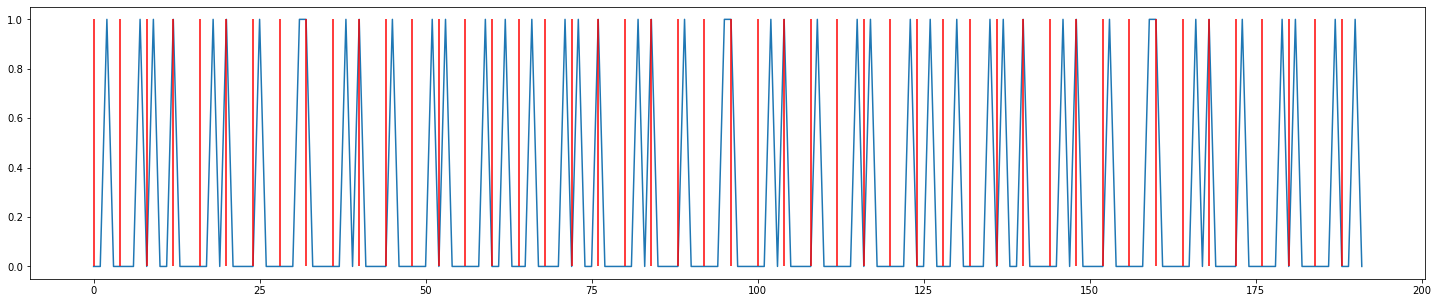

In [104]:
plt.figure(figsize=(25, 5))
plt.plot(y)
groups = [x for x in range(y.shape[0]) if x%4==0]
plt.vlines(groups, ymax=1, ymin=0, colors='r')


# predict on test

In [119]:

# clf = LinearDiscriminantAnalysis(solver='eigen', shrinkage=1)
clf = make_pipeline(StandardScaler(),
                      SVC(gamma='auto', C=1000, probability=True))
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=1000, gamma='auto', probability=True))])

In [122]:

pred = clf.predict(
    X_test)

get_performance(y_test, pred)

{'pr_scores': 0.75,
 'recall_scores': 0.75,
 'f1_scores': 0.75,
 'mcr_scores': 0.125,
 'cm_tn-fp-fn-tp': [33, 3, 3, 9]}

In [134]:
thr = .7
pred = clf.predict_proba(
    X_test)[:, 1]
pred_ = np.zeros_like(pred)
pred_[pred>thr] = 1


get_performance(y_test, pred_)

{'pr_scores': 1.0,
 'recall_scores': 0.75,
 'f1_scores': 0.8571428571428571,
 'mcr_scores': 0.0625,
 'cm_tn-fp-fn-tp': [36, 0, 3, 9]}

In [125]:
pred, y_test

(array([2.60567226e-02, 9.58083232e-01, 2.59991290e-02, 2.60066861e-02,
        1.52215019e-01, 9.58142845e-01, 2.60264500e-02, 9.68733501e-01,
        2.07327257e-02, 2.60205784e-02, 9.58105650e-01, 9.58119542e-01,
        2.60249140e-02, 1.32451607e-02, 7.01794811e-03, 2.60166750e-02,
        2.60400494e-02, 7.01794811e-03, 2.60040695e-02, 6.69557912e-01,
        1.73040804e-02, 9.58142845e-01, 2.60523600e-02, 1.52215019e-01,
        2.60470533e-02, 2.60432123e-02, 2.60362484e-02, 9.58119542e-01,
        2.44820703e-04, 2.60458167e-02, 2.60308288e-02, 2.59942432e-02,
        9.58124686e-01, 6.69557912e-01, 6.69557912e-01, 2.60607393e-02,
        8.30957560e-03, 2.60536953e-02, 8.30957560e-03, 2.60308288e-02,
        2.07327257e-02, 7.01794811e-03, 2.60205784e-02, 2.60319411e-02,
        9.58083232e-01, 1.52215019e-01, 2.44820703e-04, 2.60264500e-02]),
 array([0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
        1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.

# Ignore below 

In [8]:
datadir = '/Users/mariyana.cholakova/Documents/mnse/sem4/bspm/git_repo/biosignal_stars/data'

In [25]:
file = '/Users/mariyana.cholakova/Downloads/sub-Majd_ses-15-07-2022-short-bg_task-Default_run-008_eeg.xdf'
file = '/Users/mariyana.cholakova/Downloads/eeg/sub-Nathan_ses-long-gb_task-Default_run-003_eeg.xdf'
file = '/Users/mariyana.cholakova/Downloads/sub-Majd/ses-15-07-2022-short-bg/eeg/sub-Majd_ses-15-07-2022-short-bg_task-Default_run-008_eeg.xdf'
file = '/Users/mariyana.cholakova/Downloads/sub-Majd/ses-ses-15-07-2022-short-rg/eeg/sub-Majd_ses-ses-15-07-2022-short-rg_task-Default_run-001_eeg.xdf'

In [26]:
raw, event_arr_orig, event_id_orig = load_xdf_data(file=file)
event_arr = event_arr_orig.copy()
event_id = event_id_orig.copy()

Stream 2: Calculated effective sampling rate 253.8076 Hz is different from specified rate 128.0000 Hz.


openvibesignal --> not sure what to do with this
corrected_timestamps --> data stream
p300_markers --> marker stream
Creating RawArray with float64 data, n_channels=14, n_times=50176
    Range : 0 ... 50175 =      0.000 ...   391.992 secs
Ready.


In [64]:

# Implement the band-pass filter
flow, fhigh = 0.1, 10
raw_filt = raw.copy().filter(flow, fhigh)

# Apply Common Average Referencing.
raw_car, _ = mne.set_eeg_reference(raw_filt, 'average', copy=True, ch_type='eeg')

# Now we want to epoch our data to trials and do a baseline correction.
total_trial_duration = exp_durations['baseline_length'] + exp_durations['target_length'] + \
                       exp_durations['highlight_length'] * exp_durations['num_highlights'] + \
                       exp_durations['inter_highlight_length'] * (exp_durations['num_highlights'] )

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 4225 samples (33.008 sec)

Applying average reference.
Applying a custom ('EEG',) reference.


In [18]:
event_arr[:, 0].max(), event_arr[:, 2][-1]

(17998, 1)

In [60]:
17998/ total_trial_duration
import plotly.graph_objects as go

fig = go.Figure(go.Scatter(x=event_arr_orig[:, 0][:50], y=event_arr_orig[:, 2][:50], name='events', 
                              mode='markers',
                           marker_symbol='cross',
    marker=dict(size=[ 16]*event_arr.shape[0],
                color=event_arr_orig[:, 2]
                
               )))
fig.show()

In [66]:

from plotly.validators.scatter.marker import SymbolValidator

# raw_symbols = SymbolValidator().values
# raw_symbols

In [62]:
1448-367 - exp_durations['inter_trial_length']*1000 

981.0

In [65]:
total_trial_duration

9.75

In [67]:

flow, fhigh = 1, 15
raw_filt2 = raw.copy().filter(flow, fhigh)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 16.88 Hz)
- Filter length: 423 samples (3.305 sec)



Opening raw-browser...


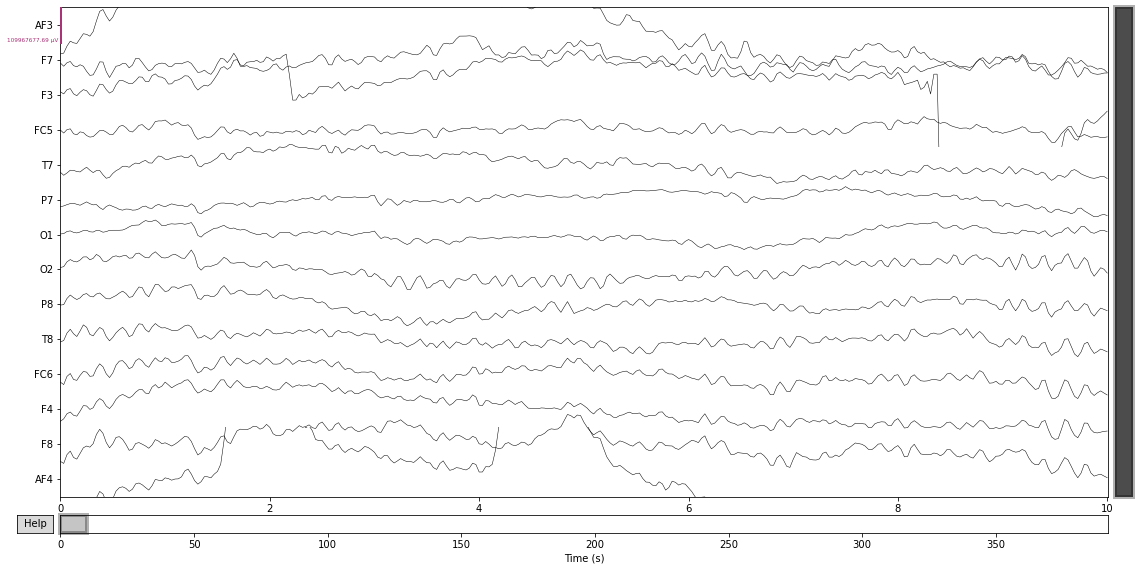

Opening raw-browser...


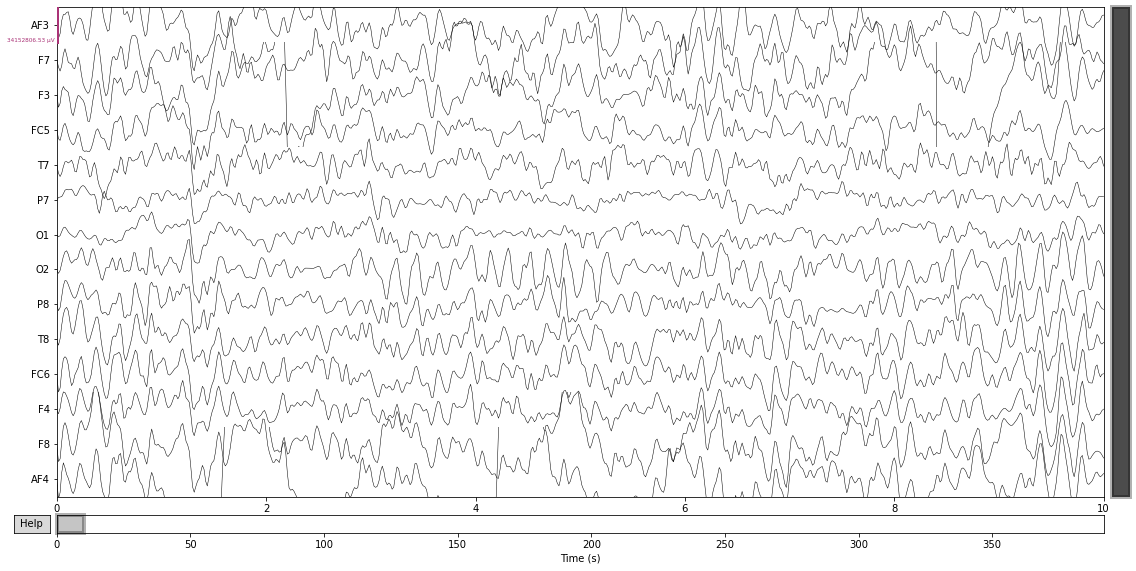

<Figure size 432x288 with 0 Axes>

In [232]:
import matplotlib
# matplotlib.use('Qt5Agg')
# f, axs = plt.subplots(2, 1, figsize=(10, 5))
# _ = f.suptitle('target / non target ', fontsize=20)
# _ = evoked_t.plot(axes=axs[0], show=False, time_unit='s')
# _ = evoked_nt.plot(axes=axs[ 1], show=False, time_unit='s')


raw_filt.plot(duration=10, proj=False, n_channels=len(raw.ch_names),
         remove_dc=True, #axes=axs[0], show=False,
             scalings='auto')
raw_filt2.plot(duration=10, proj=False, n_channels=len(raw.ch_names),
         remove_dc=True, #axes=axs[1], show=False,
             scalings='auto')

plt.tight_layout()

## P300 ?

In [68]:
 new_event_arr, new_event_id= utils.modify_events(event_arr=event_arr, event_id=event_id)

In [69]:
from global_configs import globals as GLOB

In [75]:
def get_avg_evoked(filtered_raw, event_arr_orig,event_id_orig, total_trial_duration, highlights_per_trial = 30):
    event_labels = event_arr_orig[:, 2]
    event_times = event_arr_orig[:, 0]

# inds_hd = np.where(event_labels==2)[0]
# inds_hl = np.where(event_labels==3)[0]
# inds_hr = np.where(event_labels==4)[0]
# inds_hu = np.where(event_labels==5)[0]

# times_hd = event_times[inds_hd]
# times_hl = event_times[inds_hl]
# times_hr = event_times[inds_hr]
# times_hu = event_times[inds_hu]

    inds_trial_begin = np.where(event_labels==11)[0]
    # inds_trial_begin

    inds_target_shown = np.where((event_labels>6) & (event_labels<11))[0]
    inds_target_shown

    targets_seq = event_labels[inds_target_shown]
    targets_seq

    total_trial_duration

    events_seq = event_arr_orig[:, 2]

    # target_events_seq = np.zeros_like(events_seq)

    highlight_inds = (events_seq > 1) & (events_seq < 6)
    event_arr_mod = event_arr_orig.copy()
    event_arr_mod[highlight_inds, 2] = 20

    event_id_mod = event_id_orig.copy()
    event_id_mod.update({'h': 20})


    event_id2 = {'base_trial': 0,
     'b_end': 1,
    #  'h_d': 2,
    #  'h_l': 3,
    #  'h_r': 4,
    #  'h_u': 5,
     'pause': 6,
     't_d': 7,
     't_l': 8,
     't_r': 9,
     't_u': 10,
     'tr_begin': 11,
                'h':20}
    epochs_highlights_ = mne.Epochs(raw_filt2,
                                           events=event_arr_mod,
                                           event_id= {'h':20},
                                           tmin=.1,
                                           tmax=.5,
                                           baseline=None,
                                           preload=True, 
                                   event_repeated='drop', decim=2)
    
    highlights_seq = event_arr_orig[:, 2][event_arr_mod[:, 2]==20]

    targets_final = []
    highlights_final_epochs = []
    highlights_labels = []
    j = 0

    for i in np.arange(0, len(epochs_highlights_), highlights_per_trial):
        ep = epochs_highlights_[i: i+highlights_per_trial]
        highlight_labels = highlights_seq[i: i+highlights_per_trial]
        target_ = targets_seq[j]
        j+=1
        epochs_down = ep[highlight_labels==2].average()  
        epochs_left = ep[highlight_labels==3].average()   
        epochs_right = ep[highlight_labels==4].average()    
        epochs_up = ep[highlight_labels==5].average()
        
        highlights_final_epochs.append(epochs_down)
        highlights_final_epochs.append(epochs_left)

        highlights_final_epochs.append(epochs_right)

        highlights_final_epochs.append(epochs_up)

        highlights_labels.extend([ 2,3, 4, 5])
        targets_final.extend([target_] * 4)
        t_samples = [x for x in range(len(targets_final)) if highlights_labels[x]==targets_final[x] -5]
        
    return highlights_final_epochs, targets_final, targets_seq, highlights_labels, highlights_seq, t_samples

In [474]:
thr = .5
pred = clf.predict_proba(
    x_feat_02)[:, 1]
pred_ = np.zeros_like(pred)
pred_[pred>thr] = 1
get_performance(y_02, pred_)

{'pr_scores': 0.35294117647058826,
 'recall_scores': 0.0967741935483871,
 'f1_scores': 0.1518987341772152,
 'mcr_scores': 0.2791666666666667,
 'cm_all': [167, 11, 56, 6]}

In [439]:
pred

array([0.64568696, 0.5180691 , 0.60841549, 0.78631131, 0.67655802,
       0.68754959, 0.73383653, 0.58687727, 0.78040203, 0.81851504,
       0.70823224, 0.63862363, 0.69070726, 0.68551051, 0.70823203,
       0.60633699, 0.80836431, 0.66115943, 0.55424591, 0.73294625,
       0.86666505, 0.63532777, 0.74199351, 0.58246034, 0.60827555,
       0.38436324, 0.59446531, 0.60049283, 0.55182853, 0.73837409,
       0.43216052, 0.66902315, 0.57414832, 0.57543195, 0.73383653,
       0.53160432, 0.64990059, 0.74078496, 0.66402195, 0.70823125,
       0.5547019 , 0.5       , 0.4602401 , 0.67085522, 0.64893023,
       0.74285225, 0.58466767, 0.59339387, 0.73953696, 0.27646568,
       0.55975325, 0.4571568 , 0.67870718, 0.81110718, 0.60819343,
       0.68360947, 0.46387362, 0.8300742 , 0.63204803, 0.70366137,
       0.75494412, 0.69995777, 0.56523211, 0.65479919, 0.55431063,
       0.51922946, 0.62606154, 0.75246956, 0.66445772, 0.71588566,
       0.76312318, 0.62643327, 0.73864626, 0.68379085, 0.71692

In [429]:
pred

array([0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1])

In [107]:

def get_performance(y_true, y_pred_):
    tn, fp, fn, tp  = confusion_matrix(y_true, y_pred_).ravel()

    conf_matrix = [tn, fp, fn, tp ]
    test_metrics = {
    'pr_scores': precision_score(y_true, y_pred_),
    'recall_scores': recall_score(y_true, y_pred_),
    'f1_scores': f1_score(y_true, y_pred_),
    'mcr_scores': (fp+fn)/y_true.shape[0],
    'cm_all': conf_matrix,
    }
    return test_metrics

In [184]:
from mne import (io, compute_raw_covariance, read_events, pick_types, Epochs)
from mne.datasets import sample
from mne.preprocessing import Xdawn
from mne.viz import plot_epochs_image

## Try Xdown

In [187]:
epochs_highlights_notargets2_decim = epochs_highlights_notargets2
epochs_highlights_targets2_decim = epochs_highlights_targets2

Not setting metadata
361 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


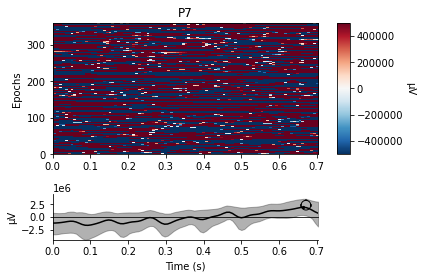

[<Figure size 432x288 with 4 Axes>]

In [278]:
ch = ['P7']
# Plot image epoch before xdawn
plot_epochs_image(epochs_highlights_notargets2_decim, picks=ch, vmin=-500000, vmax=500000
                 )

Not setting metadata
119 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


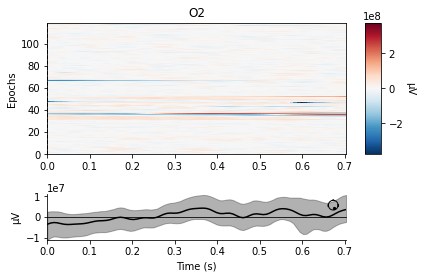

[<Figure size 432x288 with 4 Axes>]

In [188]:
# Plot image epoch before xdawn
plot_epochs_image(epochs_highlights_targets2_decim, picks=ch, vmin=-500, vmax=500 )

In [225]:
selected_channels, signal_cov

(['P8', 'FC6', 'O1', 'O2', 'P7'],
 <Covariance | size : 5 x 5, n_samples : 217359, data : [[290.58793482 161.86873387 227.28159351 148.30911837 228.20831707]
  [161.86873387 154.48129698 140.86626516 123.79665216 145.36982535]
  [227.28159351 140.86626516 257.86870035 127.97074017 192.31103189]
  [148.30911837 123.79665216 127.97074017 149.72246548 145.62423158]
  [228.20831707 145.36982535 192.31103189 145.62423158 242.52085673]]>)

In [228]:
cov = np.asarray([[290.58793482, 161.86873387, 227.28159351, 148.30911837, 228.20831707],
  [161.86873387, 154.48129698 ,140.86626516, 123.79665216 ,145.36982535],
  [227.28159351, 140.86626516 ,257.86870035, 127.97074017, 192.31103189],
  [148.30911837, 123.79665216, 127.97074017 ,149.72246548, 145.62423158],
  [228.20831707, 145.36982535, 192.31103189, 145.62423158, 242.52085673]])

In [233]:
cov.shape

(5, 5)

In [270]:
# Estimates signal covariance
signal_cov = compute_raw_covariance(raw_filt2, picks=selected_ch)

# Xdawn instance
xd = Xdawn(n_components=2, signal_cov=None)

# Fit xdawn
xd.fit(epochs_highlights_targets2_decim)

Using up to 1960 segments
Number of samples used : 50960
[done]
Computing rank from data with rank='full'
    EEG: rank 14 from info
Reducing data rank from 14 -> 14
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 14 from info
Reducing data rank from 14 -> 14
Estimating covariance using EMPIRICAL
Done.


Xdawn(correct_overlap='auto', n_components=2, reg=None, signal_cov=None)

Transforming to Xdawn space
Zeroing out 12 Xdawn components
Inverse transforming to sensor space
Not setting metadata
119 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


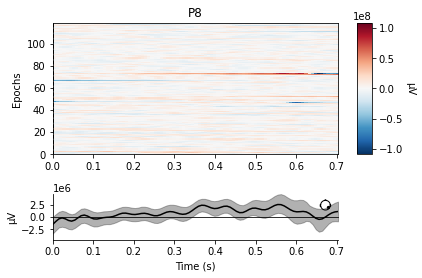

[<Figure size 432x288 with 4 Axes>]

In [273]:
epochs_denoised = xd.apply(epochs_highlights_targets2_decim)
ch = ['P8']
# Plot image epoch after Xdawn
plot_epochs_image(epochs_denoised['highlight_target_true'], picks=ch,  )

In [195]:
from mne.stats import bonferroni_correction, fdr_correction

x_0 = epochs_highlights_notargets2.get_data()[:, 0, :]
T, pval = stats.ttest_1samp(x_0, 0)
alpha = 0.05

n_samples, n_tests = x_0.shape
threshold_uncorrected = stats.t.ppf(1.0 - alpha, n_samples - 1)

reject_bonferroni, pval_bonferroni = bonferroni_correction(pval, alpha=alpha)
threshold_bonferroni = stats.t.ppf(1.0 - alpha / n_tests, n_samples - 1)

reject_fdr, pval_fdr = fdr_correction(pval, alpha=alpha, method='indep')
# threshold_fdr = np.min(np.abs(T)[reject_fdr])

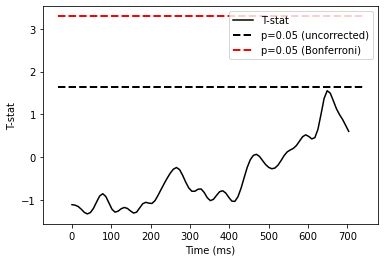

In [196]:
times = 1e3 * epochs_highlights_notargets2.times

plt.close('all')
plt.plot(times, T, 'k', label='T-stat')
xmin, xmax = plt.xlim()
plt.hlines(threshold_uncorrected, xmin, xmax, linestyle='--', colors='k',
           label='p=0.05 (uncorrected)', linewidth=2)
plt.hlines(threshold_bonferroni, xmin, xmax, linestyle='--', colors='r',
           label='p=0.05 (Bonferroni)', linewidth=2)
# plt.hlines(threshold_fdr, xmin, xmax, linestyle='--', colors='b',
#            label='p=0.05 (FDR)', linewidth=2)
plt.legend()
plt.xlabel("Time (ms)")
plt.ylabel("T-stat")
plt.show()

## pca

In [212]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
pca.fit(x_all.reshape(x_all.shape[0], -1))
x_pca = pca.transform(x_all.reshape(x_all.shape[0], -1))

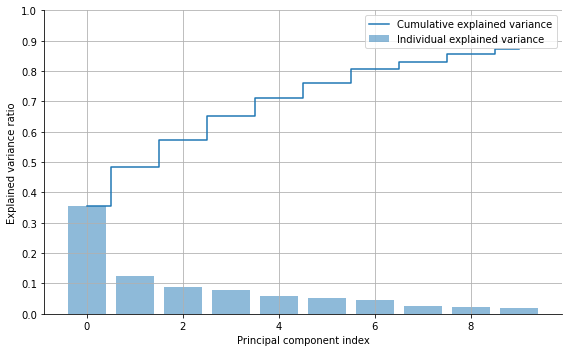

In [213]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)

exp_var_pca = pca.explained_variance_ratio_
#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
#
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
#
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
# plt.vlines(17, ymax=cum_sum_eigenvalues[17], ymin=0, colors='r')

plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.yticks(np.arange(0,1.1,.1))
plt.grid()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Optimal number of features : 25


/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


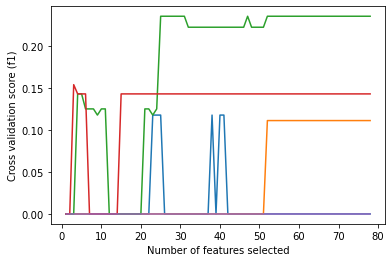

In [220]:
lda = LinearDiscriminantAnalysis('eigen', shrinkage='auto')
min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(
    estimator=lda,
    step=1,
    cv=StratifiedKFold(5),
    scoring="f1",
    min_features_to_select=min_features_to_select,
)
rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (f1)")
plt.plot(
    range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_,
)
plt.show()

In [222]:
# Construct a pipeline
pipe = Pipeline(
    [
        # the reduce_dim stage is populated by the param_grid
        ("reduce_dim", "passthrough"),
        ("scale", "passthrough"),
        ("classify", 'passthrough'),
    ]
)

from sklearn.model_selection import RepeatedKFold
shrinkage = [.5, .9 , 'auto']
N_FEATURES_OPTIONS = [2, 8, 16, 32,]
C_OPTIONS = [1000, 100]
gammas =[.001, .005, .01, .05, 0.9, 'auto']
param_grid = [
    {
        "reduce_dim": [PCA(iterated_power=7)],
        "reduce_dim__n_components": N_FEATURES_OPTIONS,
        "scale": [StandardScaler()],
        "classify": [SVC(max_iter=10000)],
        "classify__C": C_OPTIONS,

        "classify__gamma": gammas,
    },
    {
        "reduce_dim": [SelectKBest(mutual_info_classif)],
        "reduce_dim__k": N_FEATURES_OPTIONS,
        "scale": [StandardScaler()],

        "classify": [SVC(max_iter=10000)],
        "classify__gamma": gammas,
        "classify__C": C_OPTIONS,

    },
    {
        "reduce_dim":  [PCA(iterated_power=7)],
        "reduce_dim__n_components": N_FEATURES_OPTIONS,
        "classify": [LinearDiscriminantAnalysis(solver='eigen',)],
        "classify__shrinkage": shrinkage,

    },
    {
        "reduce_dim": [SelectKBest(mutual_info_classif)],
        "reduce_dim__k": N_FEATURES_OPTIONS,
        "classify": [LinearDiscriminantAnalysis(solver='eigen', )],
        "classify__shrinkage": shrinkage,

    },
]
reducer_labels = ["PCA", "KBest(mi)"]
cv =  StratifiedKFold(n_splits=10)

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=0)
grid_clf = GridSearchCV(pipe,scoring='f1', n_jobs=1, 
                    cv=cv,
                    # random_state=0,
                    param_grid=param_grid,
                    )
# # X, y = load_digits(return_X_y=True)
grid_clf.fit(X_train, y_train )

# mean_scores = np.array(grid.cv_results_["mean_test_score"])
# # scores are in the order of param_grid iteration, which is alphabetical

/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
 

/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
 

/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
 

/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
 

/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
 

/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
 

/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
 

/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
 

/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
 

/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
 

/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
 

/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
 

/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
 

/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
 

/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
 

/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
 

/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
 

/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
 

/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
 

/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
 

/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
 

/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
 

/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
 

/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
 

/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
 

/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
 

/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
 

/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
 

/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
 

/Users/mariyana.cholakova/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=10, random_state=0),
             estimator=Pipeline(steps=[('reduce_dim', 'passthrough'),
                                       ('scale', 'passthrough'),
                                       ('classify', 'passthrough')]),
             n_jobs=1,
             param_grid=[{'classify': [SVC(C=1000, gamma=0.005,
                                           max_iter=10000)],
                          'classify__C': [1000, 100],
                          'classify__gamma': [0.001, 0.005, 0.01, 0.05, 0.9,
                                              'auto'],
                          'reduce_dim': [PCA(it...
                         {'classify': [LinearDiscriminantAnalysis(solver='eigen')],
                          'classify__shrinkage': [0.5, 0.9, 'auto'],
                          'reduce_dim': [PCA(iterated_power=7)],
                          'reduce_dim__n_components': [2, 8, 16, 32]},
                         {'classify': [LinearDis

In [223]:
grid_clf.best_params_, grid_clf.best_score_

({'classify': SVC(C=1000, gamma=0.005, max_iter=10000),
  'classify__C': 1000,
  'classify__gamma': 0.005,
  'reduce_dim': PCA(iterated_power=7, n_components=32),
  'reduce_dim__n_components': 32,
  'scale': StandardScaler()},
 0.26408470070234774)